In [1]:
import pandas as pd
import numpy as np

nb_data = 50
np.random.seed(1)
# x1 = pd.DataFrame(np.random.normal(loc=np.array([np.pi, 0]), scale=np.array([[np.pi/6, np.pi/2]]), size=(1000,2)))
# x2 = pd.DataFrame(np.random.normal(loc=np.array([0, 0]), scale=np.array([[np.pi/16, np.pi/2]]), size=(1000,2)))
x1 = pd.DataFrame(np.random.normal(loc=np.array([np.pi]), scale=np.array([np.pi/8]), size=(nb_data,1)))
x2 = pd.DataFrame(np.random.normal(loc=np.array([0]), scale=np.array([np.pi/6]), size=(nb_data,1)))

In [2]:
x1 = x1 % (2 * np.pi)
x2 = x2 % (2 * np.pi)

In [3]:
X1 = pd.concat([np.cos(x1[0]),  np.sin(x1[0])], axis=1, keys=["x", "y"])
X2 = pd.concat([np.cos(x2[0]),  np.sin(x2[0])], axis=1, keys=["x", "y"])
# X2 = pd.concat([np.sin(x2[0]) * np.cos(x2[1]), np.sin(x2[0]) * np.sin(x2[1]), np.cos(x2[0])], axis=1, keys=[0,1,2])

# X = pd.concat([X1, X2], keys=["data1", "data2"], axis=1)

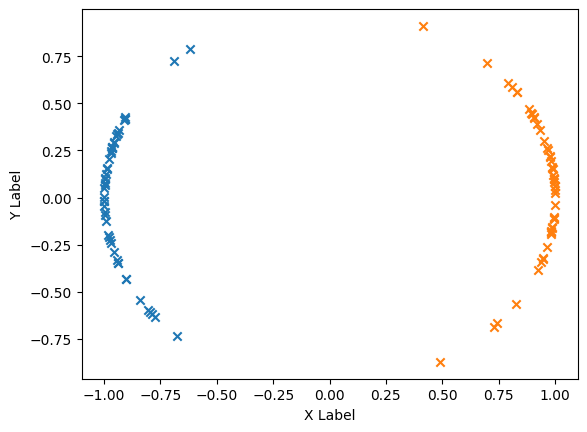

In [4]:
import matplotlib.pyplot as plt
# Fixing random state for reproducibility


fig, ax = plt.subplots()
# fig = plt.figure()

ax.scatter(X1["x"], X1["y"], marker="x")
ax.scatter(X2["x"], X2["y"], marker="x")
# ax.scatter(X2[0], X2[1], X2[2], color="orange", marker="x")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

plt.show()

In [5]:
#X.to_parquet("./cartesian_data.parquet")

In [6]:
!pip install imageio

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from geomloss import SamplesLoss

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors :
/usr/bin/ld: cannot find -lnvrtc: No such file or directory
collect2: error: ld returned 1 exit status

OK
[pyKeOps] Compiling nvrtc binder for python ... 
[KeOps] Warning : There were warnings or errors :
/usr/bin/ld: cannot find -lnvrtc: No such file or directory
collect2: error: ld returned 1 exit status

OK


In [8]:
from random import choices
from imageio import imread


def load_image(fname):
    img = imread(fname, as_gray=True)  # Grayscale
    img = (img[::-1, :]) / 255.0
    return 1 - img


def draw_samples(fname, n, dtype=torch.FloatTensor):
    A = load_image(fname)
    xg, yg = np.meshgrid(
        np.linspace(0, 1, A.shape[0]),
        np.linspace(0, 1, A.shape[1]),
        indexing="xy",
    )

    grid = list(zip(xg.ravel(), yg.ravel()))
    dens = A.ravel() / A.sum()
    dots = np.array(choices(grid, dens, k=n))
    dots += (0.5 / A.shape[0]) * np.random.standard_normal(dots.shape)

    return torch.from_numpy(dots).type(dtype)


def display_samples(ax, x, color):
    x_ = x.detach().cpu().numpy()
    ax.scatter(x_[:, 0], x_[:, 1], 25 * 500 / len(x_), color, edgecolors="none")
    
def display_samples3D(ax, x, color):
    x_ = x.detach().cpu().numpy()
    ax.scatter(x_[:, 0], x_[:, 1], x_[:, 2], s=20, c=color, edgecolors="none")  # Set a fixed size


In [9]:
X_i = torch.tensor(X1.values)
Y_j = torch.tensor(X2.values)
print(X_i.shape, Y_j.shape)

torch.Size([50, 2]) torch.Size([50, 2])


In [21]:
def gradient_descent2D(loss, lr=1, verbose=False):
    """Flows along the gradient of the loss function.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = 1):
            Learning rate, i.e. time step.
    """
    if verbose: print("Launch Gradient Descent Algo on Sinkhorn")
    # Parameters for the gradient descent
    Nsteps = 20
    display_its = [0,  6,12, 18]

    # Use colors to identify the particles
    colors = (10 * X_i[:, 0]).cos() * (10 * X_i[:, 1]).cos()
    colors = colors.detach().cpu().numpy()

    # Make sure that we won't modify the reference samples
    x_i, y_j = X_i.clone(), Y_j.clone()

    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    x_i.requires_grad = True

    t_0 = time.time()
    plt.figure(figsize=(12, 12))
    k = 1
    for i in range(Nsteps):  # Euler scheme ===============
        # Compute cost and gradient
        if verbose:
            print(f"step {i}")
        L_ab = loss(x_i, y_j)
        [g] = torch.autograd.grad(L_ab, [x_i])

        if i in display_its:  # display
            ax = plt.subplot(2, 2, k)
            k = k + 1
            plt.set_cmap("hsv")
            plt.scatter(
                [10], [10]
            )  # shameless hack to prevent a slight change of axis...

            display_samples(ax, y_j, [(0.55, 0.55, 0.95)])
            display_samples(ax, x_i, colors)

            ax.set_title("it = {}".format(i))

            plt.axis([-1, 1, -1, 1])
            plt.gca().set_aspect("equal", adjustable="box")
            plt.xticks([], [])
            plt.yticks([], [])
            plt.tight_layout()

        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * g
    plt.title(
        "it = {}, elapsed time: {:.2f}s/it".format(i, (time.time() - t_0) / Nsteps)
    )
    plt.savefig("./test.png")

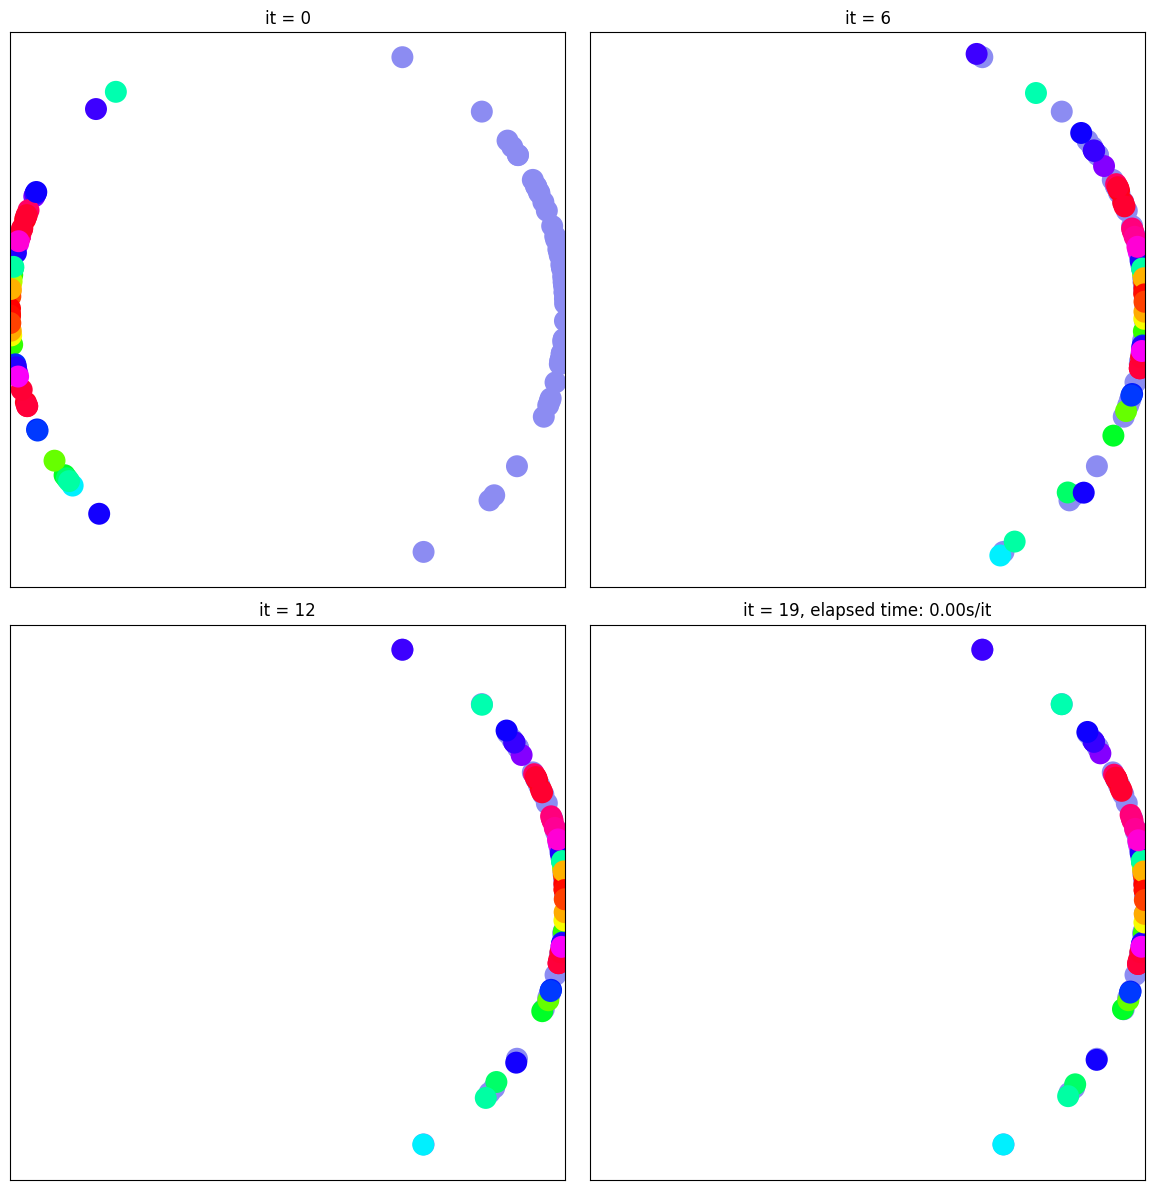

In [22]:
gradient_descent2D(SamplesLoss("sinkhorn", p=2, blur=0.1))

all tangent computed
Launch Gradient Descent Algo on Sinkhorn
step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19


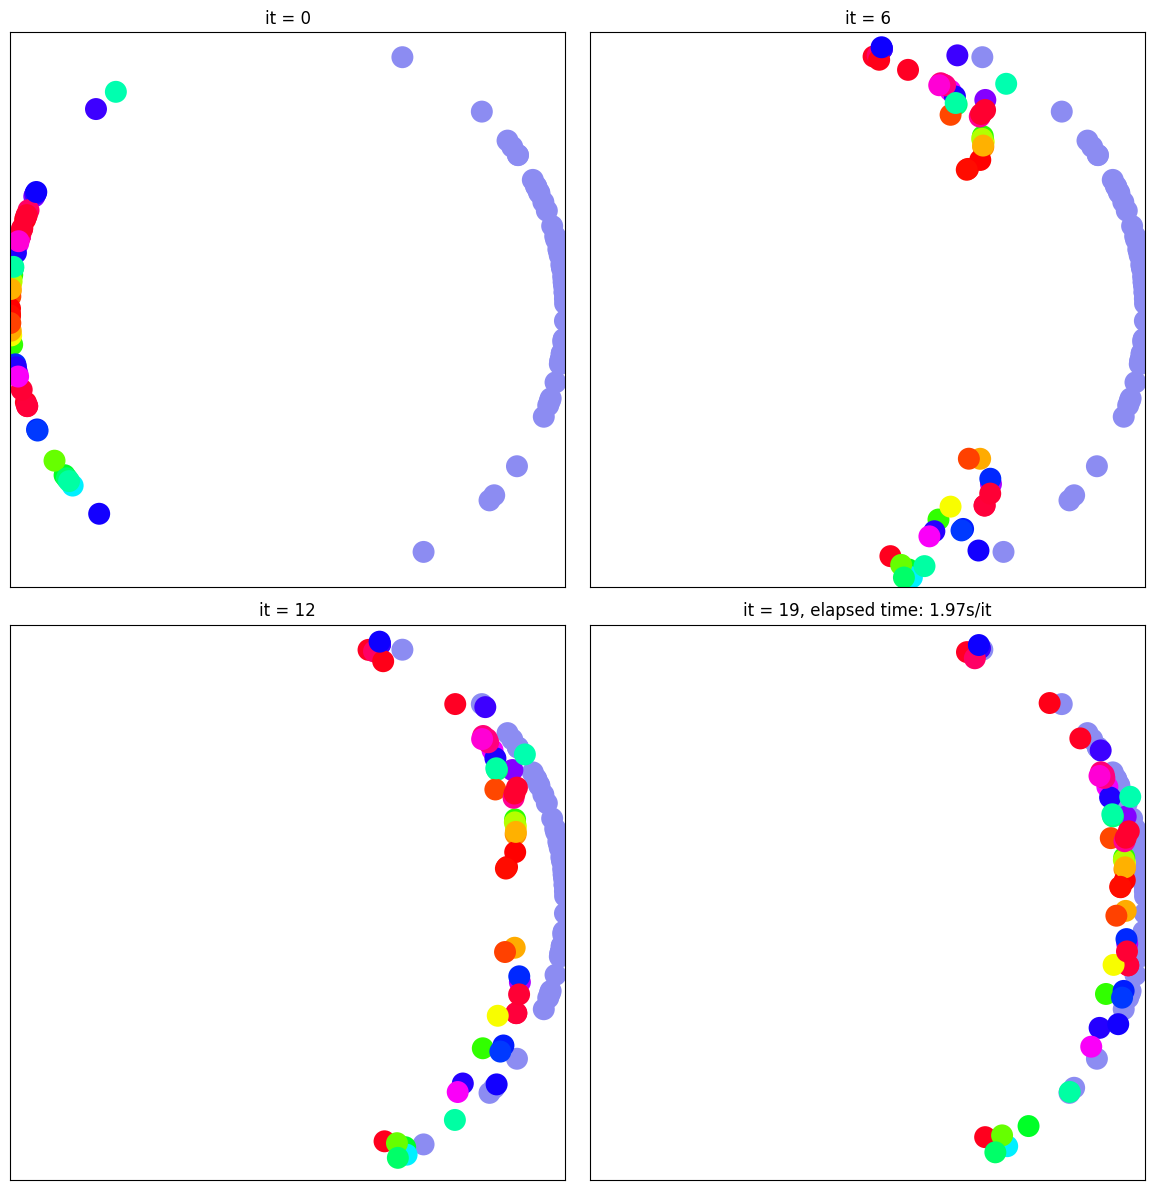

In [24]:
from ManifoldProjectLoss import ManifoldProjection, BatchingCostModule
from gen_geometry import uniform_circ
data_circ = torch.tensor(uniform_circ(200))
cost = ManifoldProjection(data_circ, k_neighbor=5, closing_manifold_ratio=0.1, manifold_ratio=0.5)
cost.precompute_all_cache()
print("all tangent computed")
cost_batched = BatchingCostModule(cost)
gradient_descent2D(SamplesLoss("sinkhorn", p=2, blur=0.1, cost=cost_batched), verbose=True, lr=0.1)

In [13]:
import numpy as np


def get_cartesia_on_sphere(phi,theta):
    # Convert spherical coordinates to Cartesian coordinates
    x =  np.sin(theta) * np.cos(phi)
    y =  np.sin(theta) * np.sin(phi)
    z =  np.cos(theta)
    return np.array([x, y, z]).T

def polar_coordinate_on_sphere(X):
    theta = torch.arccos(X[2])
    phi = torch.sign(X[1]) * torch.arccos(X[0] / torch.sqrt(X[0]**2 + X[1]**2))
    return phi, theta




def gen_points_sphere3D(num_points = 1000):
    # Generate random points on a sphere using spherical coordinates
    phi = np.random.uniform(0, 2 * np.pi, num_points)  # Azimuthal angle
    theta = np.random.uniform(0, np.pi, num_points)  # Polar angle
    return get_cartesia_on_sphere(phi, theta)

def gen_points_lower(num_points = 1000):
    phi = np.random.uniform(-np.pi/4, np.pi/4, num_points)  # Azimuthal angle
    theta = np.random.uniform(-np.pi/4, np.pi/4, num_points)  # Polar angle
    return get_cartesia_on_sphere(phi, theta)



In [14]:
X = torch.tensor(gen_points_lower())
Y = torch.tensor(-1 * gen_points_lower())

In [15]:
def plot_3D(x,y,z, ax = None):
    # Create 3D plot
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(x, y, z, c='b', marker='o', alpha=0.4)
    
    # Set plot labels and title
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    

In [16]:

def gradient_descent3D(X, Y, loss, lr=1):
    """Flows along the gradient of the loss function.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = 1):
            Learning rate, i.e. time step.
    """

    # Parameters for the gradient descent
    Nsteps = 51
    #display_its = [0, 10, 25, 50]
    display_its = [0, 1, 2, 3]
    # Use colors to identify the particles
    colors = (10 * X[:, 0]).cos() * (10 * X[:, 1]).cos()
    colors = colors.detach().cpu().numpy()

    # Make sure that we won't modify the reference samples
    x_i, y_j = X.clone(), Y.clone()

    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    x_i.requires_grad = True

    t_0 = time.time()
    plt.figure(figsize=(12, 12))
    k = 1
    for i in range(Nsteps):  # Euler scheme ===============
        # Compute cost and gradient
        L_ab = loss(x_i, y_j)
        [g] = torch.autograd.grad(L_ab, [x_i])

        if i in display_its:  # display
            ax = plt.subplot(2,2,k, projection='3d')
            k = k + 1
            display_samples3D(ax, y_j, len(y_j)*[(0.55, 0.55, 0.95)])
            display_samples3D(ax, x_i, colors)

            ax.set_title("it = {}".format(i))

            plt.gca().set_aspect("equal", adjustable="box")
            plt.xticks([], [])
            plt.yticks([], [])
            plt.tight_layout()

        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * g
    plt.title(
        "it = {}, elapsed time: {:.2f}s/it".format(i, (time.time() - t_0) / Nsteps)
    )
    plt.savefig("./test.png")

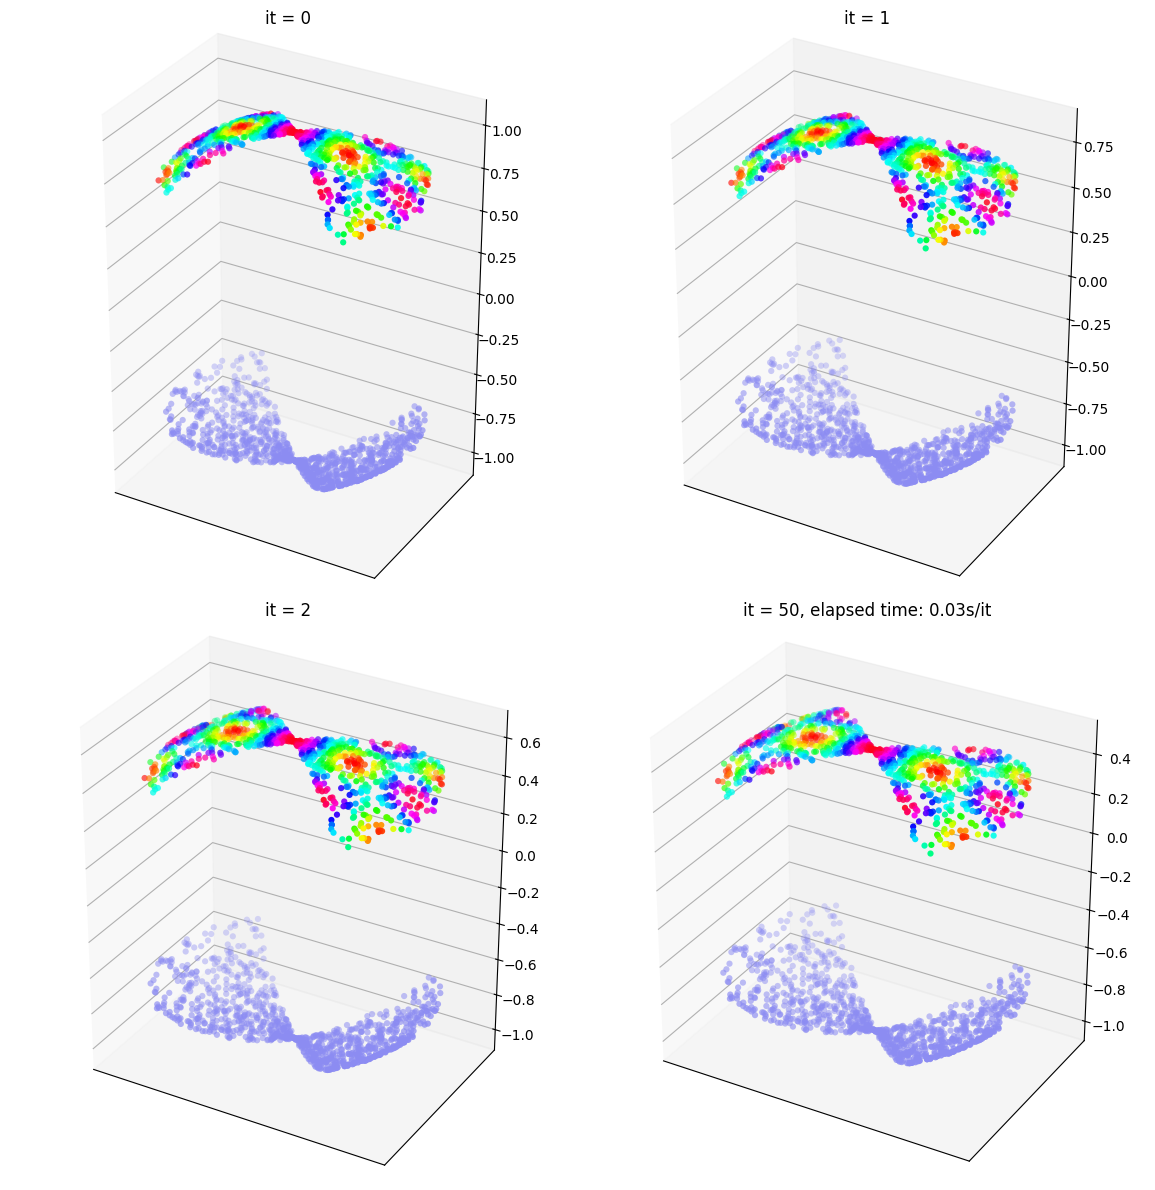

In [17]:
gradient_descent3D(X,Y,SamplesLoss("sinkhorn", p=2, blur=0.1,), lr=0.1)

ValueError: arange: cannot compute length

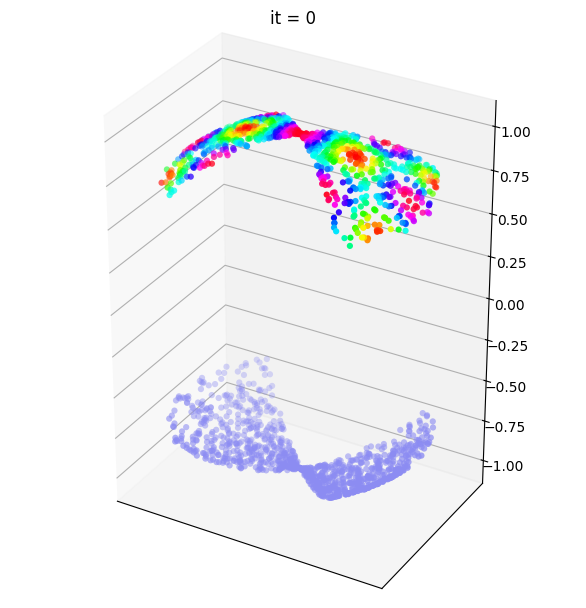

In [18]:
def polar_coordinate_on_sphere_batched(X):
    # X: A (B, N, 3) tensor representing N points in 3D for B batches.
    
    theta = torch.arccos(X[:,:,2])
    phi = torch.atan2(X[:,:,0], X[:,:,1])
    return phi, theta

def geodesic_distance_sphere(X1,X2):
    phi1, theta1 = polar_coordinate_on_sphere_batched(X1)
    phi2, theta2 = polar_coordinate_on_sphere_batched(X2)

    # Calculate the angular distance
    delta_sigma = torch.arccos(
        torch.sin(theta1.unsqueeze(2)) * torch.sin(theta2.unsqueeze(1)) + 
        torch.cos(theta1.unsqueeze(2)) * torch.cos(theta2.unsqueeze(1)) * 
        torch.cos(phi1.unsqueeze(2) - phi2.unsqueeze(1))
    )
    return delta_sigma

gradient_descent3D(X,Y,SamplesLoss("sinkhorn", p=2, blur=0.1,cost=geodesic_distance_sphere), lr=0.1)